# Performance Tuning - Understanding Parameters Impact 

A modern IT system comes with hundreds of tunable parameters. Selecting the proper configuration is crucial to extract all the available performance and save costs.
When exploring huge search spaces, random search is surprisingly effective at finding optima.
We can thus replicate the environment and run a series of performance tests, collecting data and finding good configurations.
After the search is completed, we need to transfer the best configuration found in the production deployment.
However, modifying a parameter is a risky business, hence we need to minimise the number of parameters to modify, while maintaining good performance.

## Data loading
Here we have an example dataset, collected on the MongoDB DBMS while tuning some MongoDB and Linux parameters while monitoring the MongoDB throughput.

- Each line represents an experiment (the first is the baseline, or vendor default configuration).
- The first column is the experiment_id.
- The second column is the target performance metric (to be maximized in this case).
- Other columns contain the applied parameters (some are categoricals).

Let's open the dataset and have a look:

In [1]:
import pandas as pd
filename = 'polimi.csv'
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 38 columns):
 #   Column                                                      Non-Null Count  Dtype  
---  ------                                                      --------------  -----  
 0   experiment_id                                               90 non-null     int64  
 1   throughput (ops/sec)                                        90 non-null     float64
 2   parameter-MongoDB.mongodb_cache_size (megabytes)            90 non-null     int64  
 3   parameter-MongoDB.mongodb_eviction_dirty_target (percent)   90 non-null     int64  
 4   parameter-MongoDB.mongodb_eviction_dirty_trigger (percent)  90 non-null     int64  
 5   parameter-MongoDB.mongodb_syncdelay (seconds)               90 non-null     int64  
 6   parameter-OS.os_CPUSchedAutogroupEnabled                    90 non-null     int64  
 7   parameter-OS.os_CPUSchedChildRunsFirst                      90 non-null     int64  
 8   pa

In [2]:
# first column is the id (useless), then we have the metric and all the
# parameters
y = df.iloc[:, 1]
X = df.iloc[:, 2:]

### Normalization
Our idea is to use a Random Forest (RF) as a regression model to make predictions about the performance of candidate configurations.
To build a better model, we normalise the target variable (throughput) with a common function in performance tuning: the Normalized Performance Improvement (NPI).
NPI is defined as the achieved performance improvement over the available performance improvement. The baseline configuration thus has a NPI of 0 and the best configuration a NPI of 1.

<IPython.core.display.Javascript object>


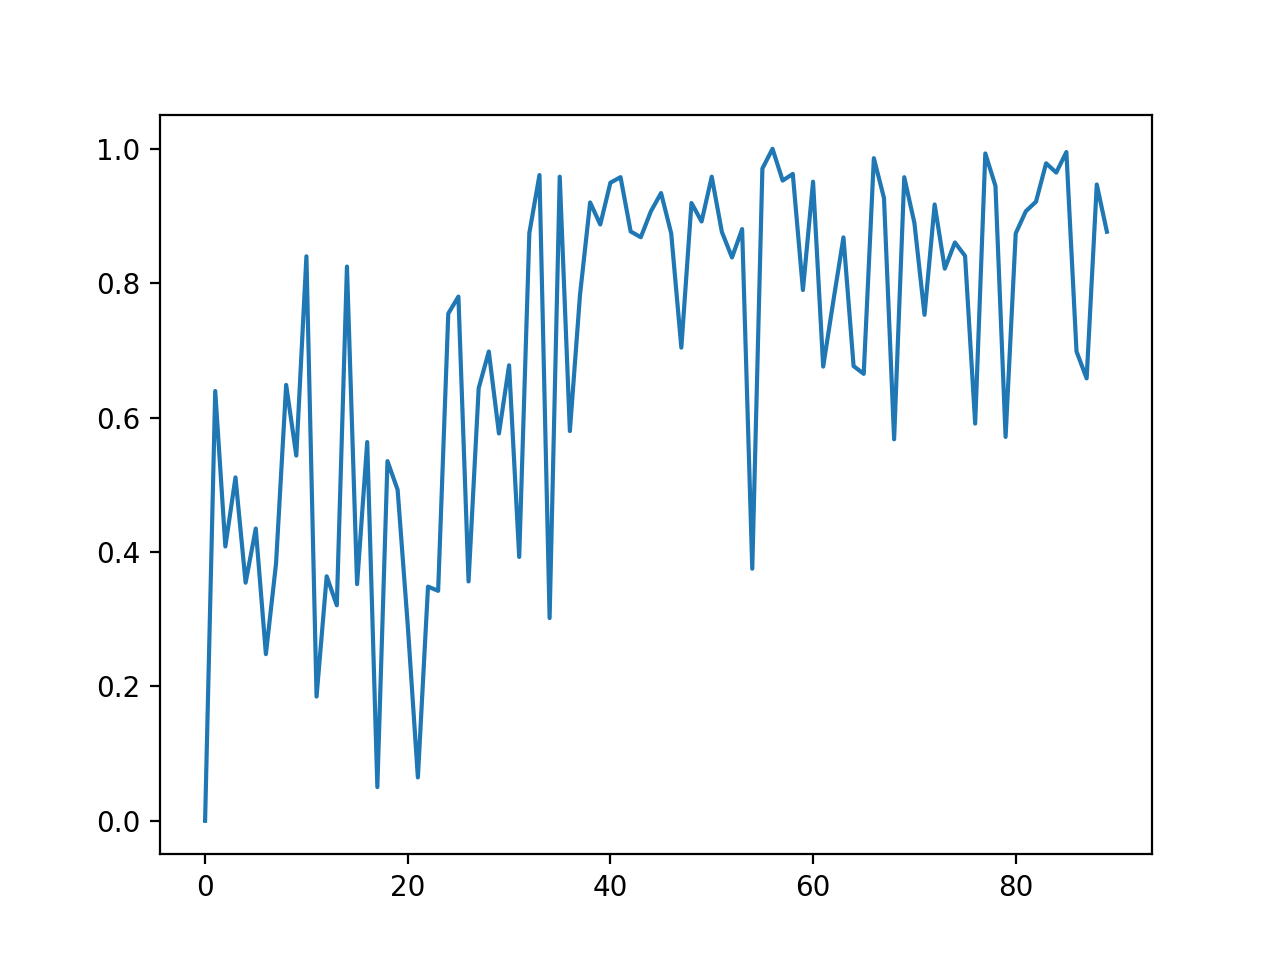

In [3]:
# npi = (y - baseline) / (best - baseline)
# the baseline is the first line
y = (y - y[0]) / (max(y) - y[0])

%matplotlib notebook
import matplotlib.pyplot as plt
plt.plot(y)
plt.show()
# Clearly, we did not use a random search

### Feature prepearation and model creation
Here is some boilerplate code for common preliminary steps:
- we split the dataset in train and validation subsets
- we transform categorical features using a one-hot encoder.

At the end, we fit a Random Forest Regressor:

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Other examples: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_categorical.html
categorical_columns = X.dtypes == 'object'
numerical_columns = X.dtypes != 'object'
categorical_encoder = OneHotEncoder()
preprocessing = ColumnTransformer([('cat', categorical_encoder, categorical_columns)],
                                  remainder='passthrough')
# now we can fit the RF
rf = Pipeline([
    ('preprocess', preprocessing),
    ('regressor', RandomForestRegressor(random_state=42))
])
rf.fit(X_train, y_train)
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 0.977
RF test accuracy: 0.858


## Solution 1: using RF feature importance

<IPython.core.display.Javascript object>


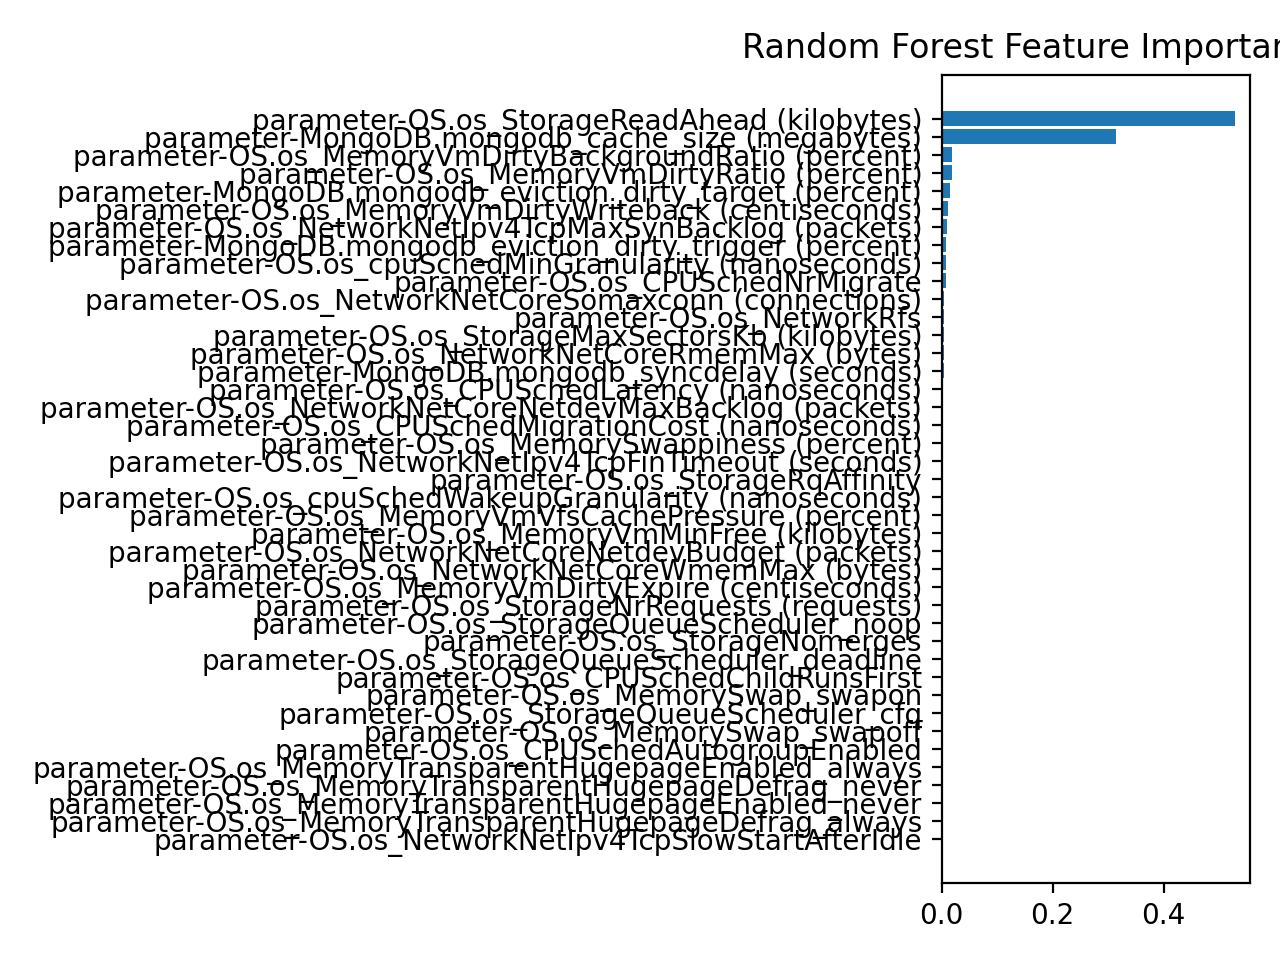

<ipython-input-5-133ef99c8f54>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_names[sorted_idx])


In [5]:
import numpy as np
# this is some boilerplate code to print the feature names, nothing relevant
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat'])
feature_names = ohe.get_feature_names(input_features=X.columns[categorical_columns])
feature_names = np.r_[feature_names, X.columns[numerical_columns]]

tree_feature_importances = (
    rf.named_steps['regressor'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()
plt.show()